# Fraud Detection Project

## Load and Explore the Dataset
This dataset contains credit card transactions from European cardholders over two days in September 2013.
- Fraudulent transactions make up only **0.172%** of all transactions, making this a highly imbalanced dataset.
- Features `V1` to `V28` are PCA-transformed, so their exact meanings are unknown.
- `Amount` is the transaction value, and `Time` represents the seconds elapsed since the first transaction.


In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv("creditcard.csv")

# Dataset summary
print(f"Dataset contains {data.shape[0]} rows and {data.shape[1]} columns.")
print("Columns in the dataset:")
print(data.columns)

# Display the first few rows
data.head()

Dataset contains 284807 rows and 31 columns.
Columns in the dataset:
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Explore the Target Variable (`Class`)
The `Class` column represents whether a transaction is fraudulent:
- **0**: Non-Fraudulent
- **1**: Fraudulent

Since the dataset is highly imbalanced, we will visualize the class distribution to confirm this imbalance.


C:\Users\brand\AppData\Local\Temp\ipykernel_9904\2341977045.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




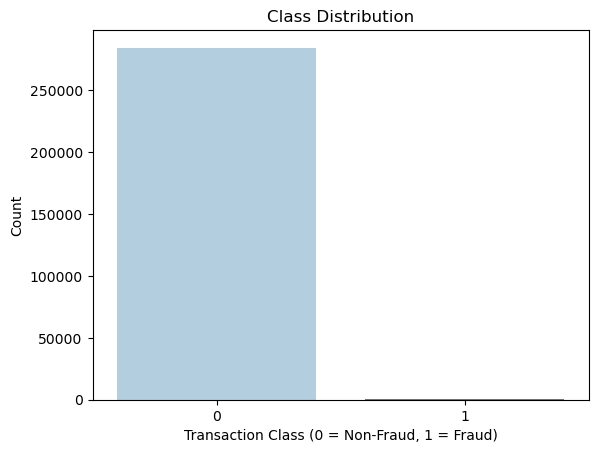

Fraudulent transactions account for 0.173% of all transactions.


In [23]:
# Visualize the target variable
sns.countplot(x='Class', data=data, palette='Blues')
plt.title("Class Distribution")
plt.xlabel("Transaction Class (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Count")
plt.show()

# Print class proportions
fraud_percentage = (data['Class'].mean()) * 100
print(f"Fraudulent transactions account for {fraud_percentage:.3f}% of all transactions.")

## Analyze Key Features
The dataset includes:
- PCA-transformed features (`V1` to `V28`): Numerical representations of the original features, transformed for privacy.
- `Amount`: Transaction value.
- `Time`: Seconds elapsed since the first transaction.

### Analysis Goals:
1. Identify patterns in fraud using `Amount` and `Time`.
2. Visualize how fraud cases differ from non-fraud cases.

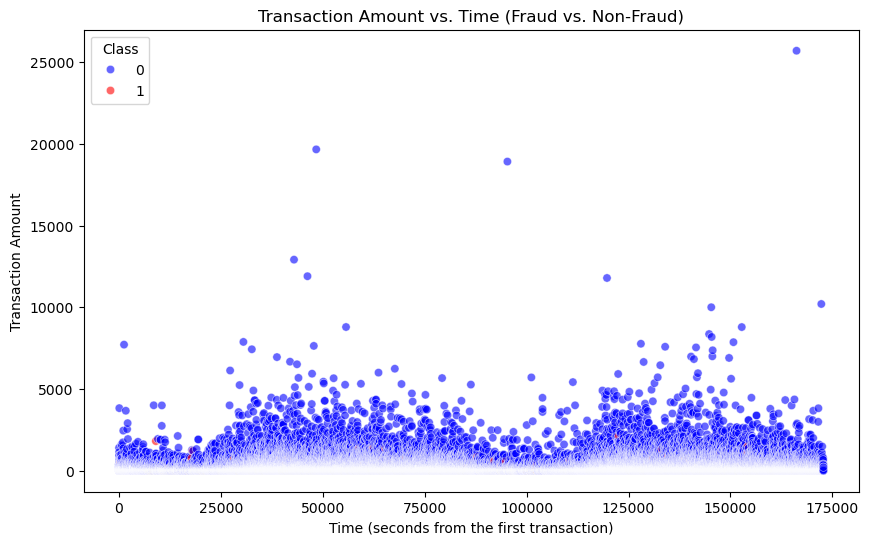

Transaction Amount Statistics (by Class):
          count        mean         std  min   25%    50%     75%       max
Class                                                                      
0      284315.0   88.291022  250.105092  0.0  5.65  22.00   77.05  25691.16
1         492.0  122.211321  256.683288  0.0  1.00   9.25  105.89   2125.87


In [24]:
# Scatter plot: Amount vs. Time
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Time', y='Amount', hue='Class', data=data, palette={0: 'blue', 1: 'red'}, alpha=0.6)
plt.title("Transaction Amount vs. Time (Fraud vs. Non-Fraud)")
plt.xlabel("Time (seconds from the first transaction)")
plt.ylabel("Transaction Amount")
plt.show()

# Statistical summary of 'Amount'
print("Transaction Amount Statistics (by Class):")
print(data.groupby('Class')['Amount'].describe())

## Step 4: Preprocessing
1. **Normalize `Amount`**: Scale the transaction amount to standardize its range.
2. **Drop `Time`**: The `Time` feature has limited predictive value based on prior analysis.
3. **Prepare Features (`X`) and Target (`y`)**: Separate input features and target variabe.


In [25]:
from sklearn.preprocessing import StandardScaler

# Normalize the 'Amount' feature
scaler = StandardScaler()
data['NormAmount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))

# Drop irrelevant columns
data = data.drop(['Time', 'Amount'], axis=1)

# Features and Target
X = data.drop('Class', axis=1)
y = data['Class']


## Handling Class Imbalance
Since fraudulent transactions are rare, we use **SMOTE** (Synthetic Minority Oversampling Technique) to balance the dataset.
- SMOTE generates synthetic samples for the minority class (fraudulent transactions).
- This ensures the model learns to detect fraud effectively without being biased toward the majority class.


In [26]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# Check the new class distribution
print("Class Distribution After Applying SMOTE:")
print(pd.Series(y_resampled).value_counts())

Class Distribution After Applying SMOTE:
Class
0    284315
1    284315
Name: count, dtype: int64


## Splitting the Model
Split the balanced dataset into training and testing sets to evaluate the model on unseen data.
- **Training Set**: 80% of the data for training the model.
- **Testing Set**: 20% of the data for evaluation.


In [27]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
print("Data split into training and testing sets.")

Data split into training and testing sets.


## Training the Model
We use a **Random Forest Classifier** because:
1. It handles imbalanced data well.
2. It is robust to overfitting.
3. It provides feature importance scores, useful for understanding which PCA components contribute most to predictions.


In [28]:
from sklearn.ensemble import RandomForestClassifier

# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print("Model training complete.")

Model training complete.


## Model Evaluation
We evaluate the model using:
1. **Precision-Recall Curve**: This is more meaningful for imbalanced datasets.
2. **Confusion Matrix**: To understand false positives and false negatives.


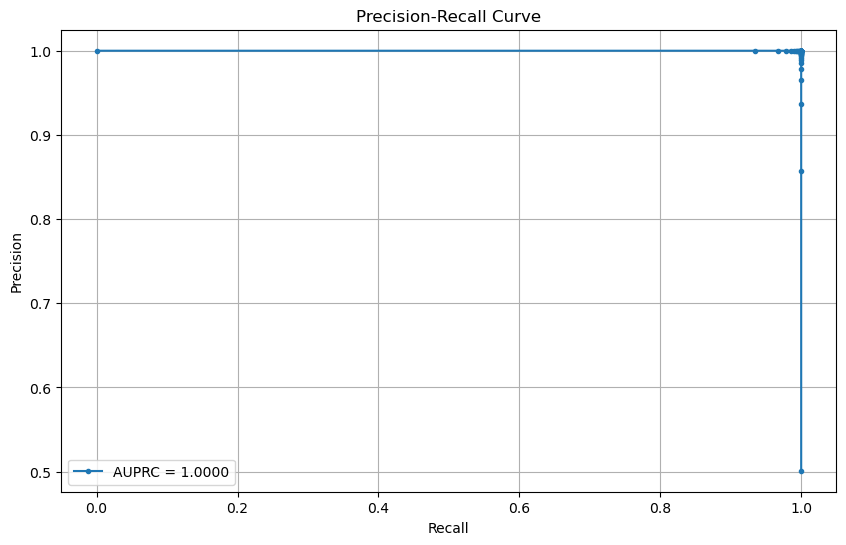

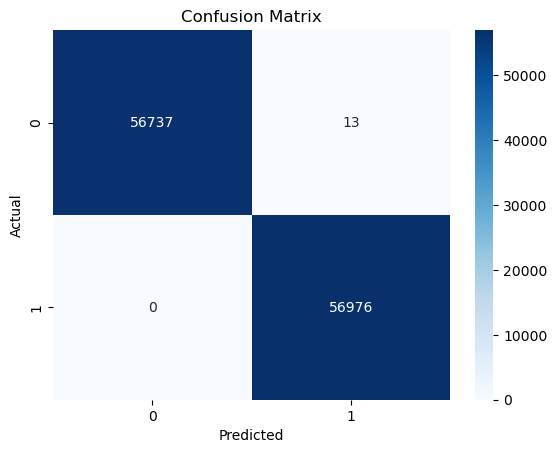

In [29]:
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix
import matplotlib.pyplot as plt

# Predict probabilities
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', label=f"AUPRC = {average_precision:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix
y_pred = (y_pred_proba >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Analyze Feature Importance
Analyze which PCA-transformed features (`V1` to `V28`) contribute most to the model's predictions


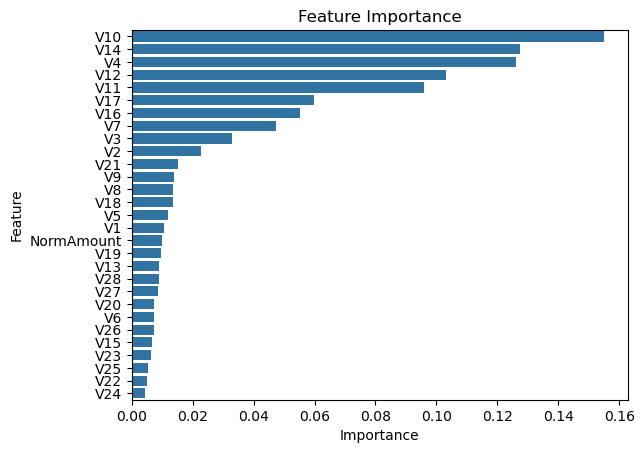

In [30]:
# Feature importance
importances = rf.feature_importances_
features = X.columns
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title("Feature Importance")
plt.show()